Epoch 1/10
28258/28258 [==============================] - 15s 529us/step - loss: 0.7458 - accuracy: 0.6905 - val_loss: 0.7000 - val_accuracy: 0.7111
Epoch 2/10
28258/28258 [==============================] - 15s 520us/step - loss: 0.6792 - accuracy: 0.7230 - val_loss: 0.6701 - val_accuracy: 0.7257
Epoch 3/10
28258/28258 [==============================] - 15s 519us/step - loss: 0.6669 - accuracy: 0.7290 - val_loss: 0.6658 - val_accuracy: 0.7300
Epoch 4/10
28258/28258 [==============================] - 15s 521us/step - loss: 0.6597 - accuracy: 0.7319 - val_loss: 0.6592 - val_accuracy: 0.7324
Epoch 5/10
28258/28258 [==============================] - 15s 521us/step - loss: 0.6549 - accuracy: 0.7345 - val_loss: 0.6516 - val_accuracy: 0.7365
Epoch 6/10
28258/28258 [==============================] - 15s 520us/step - loss: 0.6510 - accuracy: 0.7363 - val_loss: 0.6535 - val_accuracy: 0.7345
Epoch 7/10
28258/28258 [==============================] - 15s 520us/step - loss: 0.6474 - accuracy: 0.7388

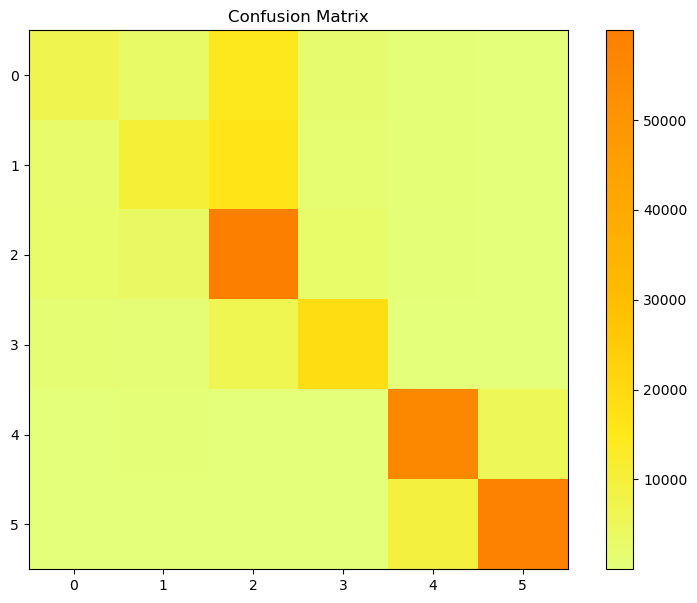

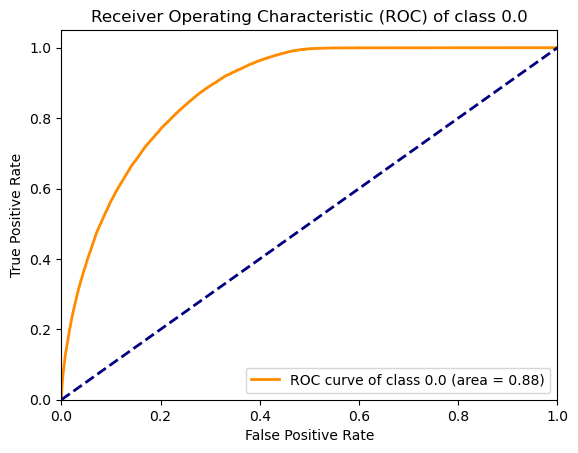

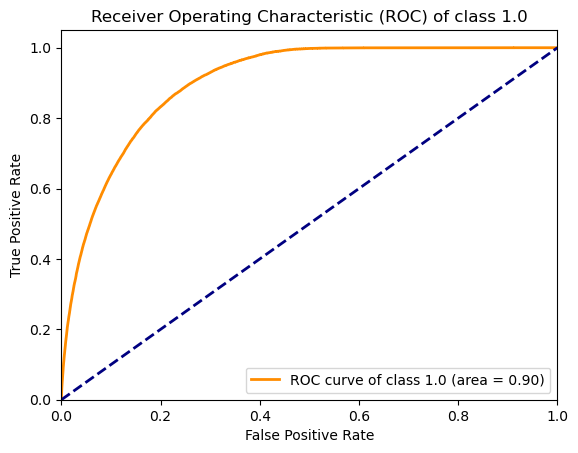

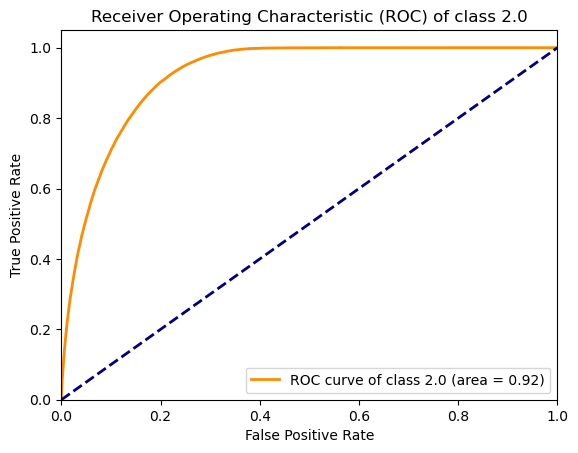

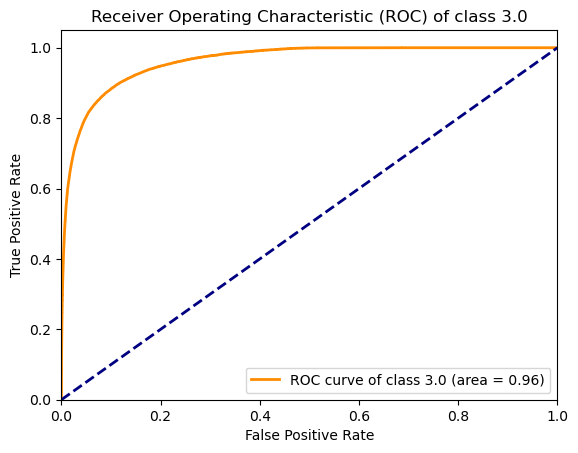

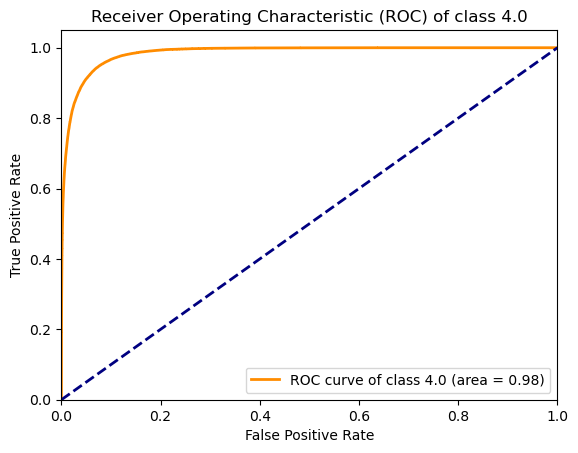

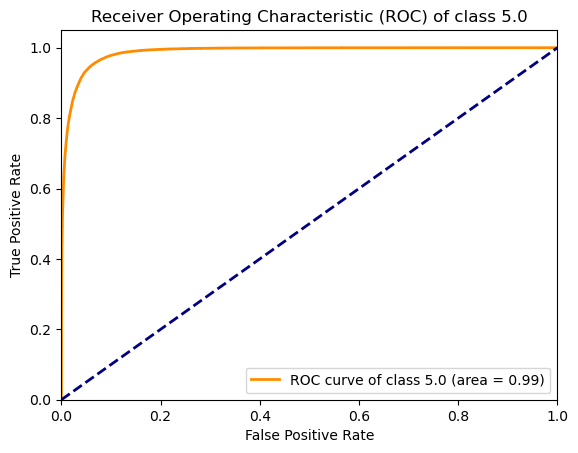

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                     preprocess='standard', test_size=0.2, random_state=None, 
                     epochs=10, batch_size=32, save_model=False):

    # Load Data
    dataset = pd.read_csv(file_path)
    
    # Prepare features and labels
    X = dataset.drop(columns=[target]).values
    y = pd.get_dummies(dataset[target]).values if task == 'multi_class' else dataset[target].apply(lambda x: 1 if x == positive_label else 0).values
    
    # Preprocess
    if preprocess == 'standard':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    elif preprocess == 'normal':
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)

    # Build Model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', metrics=['accuracy'])
    
    # Train
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Evaluate
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

    # Plot ROC curve for each class
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        for i, label in enumerate(dataset[target].unique()):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Save Model
    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean.csv'
results = train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                 preprocess='standard', test_size=0.2, 
                 random_state=42, epochs=10, batch_size=32, 
                 save_model=True)
